In [61]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import cv2
import glob
from tensorflow.keras.preprocessing import image_dataset_from_directory


CWD_PATH = os.getcwd()
MODEL_PATH = os.path.join(CWD_PATH, 'train_models')
MODEL_NAME = 'FLOWER_BS32_EPOCH200_DROPOUT00'
MODEL_NAME_PATH = os.path.join(MODEL_PATH,MODEL_NAME)
SAVED_MODEL_PATH = os.path.join(MODEL_NAME_PATH, '{}_model'.format(MODEL_NAME))
SAVED_FINETUNE_MODEL_PATH = os.path.join(MODEL_NAME_PATH, '{}_finetune_model'.format(MODEL_NAME))
DATA_PATH = os.path.join(CWD_PATH, 'flower_photos')



BATCH_SIZE = 32
IMG_SIZE = (224, 224)
SHAPE_SIZE = (224,224,3)
VALIDATION_SPLIT = 0.2
STEPS_PER_EPOCH = 1
initial_epochs = 200
fine_tune_epochs = 200
final_batch_size = 32
DROPU_OUT = 0.0
base_learning_rate = 0.0001
AUTOTUNE = tf.data.experimental.AUTOTUNE
if not os.path.exists(MODEL_NAME_PATH):
    os.mkdir(MODEL_NAME_PATH)

In [62]:
data_augmentation = tf.keras.Sequential(
  [
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
    tf.keras.layers.experimental.preprocessing.RandomZoom(0.1),
    tf.keras.layers.experimental.preprocessing.RandomContrast(0.1),
  ]
)

In [63]:
train_dataset = image_dataset_from_directory(DATA_PATH,
                                             shuffle=True,
                                             validation_split=VALIDATION_SPLIT,
                                             subset="training",
                                             seed=123,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)

validation_dataset = image_dataset_from_directory(DATA_PATH,
                                                  shuffle=True,
                                                  validation_split=VALIDATION_SPLIT,
                                                  subset="validation",
                                                  seed=123,                                                  
                                                  batch_size=BATCH_SIZE,
                                                  image_size=IMG_SIZE)

class_names = train_dataset.class_names

print('classes ', class_names)

## take 1 / 5 batch for test data
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

print('Number of training batches: %d' % tf.data.experimental.cardinality(train_dataset))
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))

train_dataset = train_dataset.cache().prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.cache().prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

Found 3573 files belonging to 5 classes.
Using 2859 files for training.
Found 3573 files belonging to 5 classes.
Using 714 files for validation.
classes  ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']
Number of training batches: 90
Number of validation batches: 19


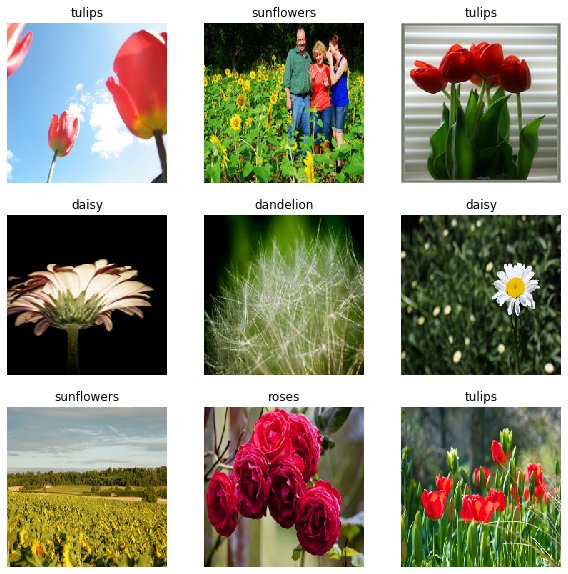

In [64]:
#visualize train data
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [65]:
# define callbacks
csv_logger = tf.keras.callbacks.CSVLogger(os.path.join(MODEL_NAME_PATH,"model_history_log.csv"), append=True)
check_point_filepath = os.path.join(MODEL_NAME_PATH,"check_point_model.h5")
check_point_filepath_finetune = os.path.join(MODEL_NAME_PATH,"check_point_model_finetune.h5")
checkpoint = tf.keras.callbacks.ModelCheckpoint(check_point_filepath, monitor='loss', verbose=1, save_freq='epoch', save_best_only=True, mode='min')
checkpoint_finetune = tf.keras.callbacks.ModelCheckpoint(check_point_filepath_finetune, monitor='loss', verbose=1, save_freq='epoch', save_best_only=True, mode='min')
earlyStop = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5,min_delta=0.0)

normal_callbacks = [csv_logger,checkpoint,earlyStop]
finetune_callbacks = [csv_logger,checkpoint_finetune,earlyStop]


In [66]:
# define loss Object
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

def get_optimizer(reduce_learning=False):
    if(reduce_learning):
        return tf.keras.optimizers.Adam(lr=base_learning_rate)
    else:
        return tf.keras.optimizers.Adam()

optimizer_finetune = tf.keras.optimizers.RMSprop(lr=base_learning_rate/10)

In [67]:
base_model = tf.keras.applications.MobileNetV2(input_shape=SHAPE_SIZE, include_top=False, weights='imagenet')
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
#feature extraction
base_model.trainable = False
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_7[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
_______________________________________________________________________________

In [68]:
## data augmentation & drop out to overcome the overfit
 
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
#softmax set the Dense with number of classes
prediction_layer = tf.keras.layers.Dense(len(class_names), activation = 'softmax')
inputs = tf.keras.Input(shape=SHAPE_SIZE)
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
if(DROPU_OUT > 0):
    x = tf.keras.layers.Dropout(DROPU_OUT)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs, name=MODEL_NAME)
model.summary()

Model: "FLOWER_BS32_EPOCH200_DROPOUT00"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
sequential_3 (Sequential)    (None, 224, 224, 3)       0         
_________________________________________________________________
tf_op_layer_RealDiv_3 (Tenso [(None, 224, 224, 3)]     0         
_________________________________________________________________
tf_op_layer_Sub_3 (TensorFlo [(None, 224, 224, 3)]     0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_3 ( (None, 1280)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 

In [69]:
model.compile(optimizer=get_optimizer(),loss=loss_object,metrics=['accuracy'])

19/19 [==============================] - 1s 37ms/step - loss: 1.6050 - accuracy: 0.2304
initial loss: 1.61
initial accuracy: 0.23
Epoch 1/200
89/90 [============================>.] - ETA: 0s - loss: 1.2789 - accuracy: 0.6654
Epoch 00001: loss improved from inf to 1.27842, saving model to /home/williamkhoo/Desktop/projects/github/flower_classification/train_models/FLOWER_BS32_EPOCH200_DROPOUT00/check_point_model.h5
90/90 [==============================] - 6s 62ms/step - loss: 1.2784 - accuracy: 0.6656 - val_loss: 1.1185 - val_accuracy: 0.8362
Epoch 2/200
89/90 [============================>.] - ETA: 0s - loss: 1.1002 - accuracy: 0.8392
Epoch 00002: loss improved from 1.27842 to 1.10010, saving model to /home/williamkhoo/Desktop/projects/github/flower_classification/train_models/FLOWER_BS32_EPOCH200_DROPOUT00/check_point_model.h5
90/90 [==============================] - 6s 72ms/step - loss: 1.1001 - accuracy: 0.8391 - val_loss: 1.0688 - val_accuracy: 0.8703
Epoch 3/200
89/90 [===========

88/90 [============================>.] - ETA: 0s - loss: 0.9730 - accuracy: 0.9396
Epoch 00046: loss did not improve from 0.97056
90/90 [==============================] - 4s 40ms/step - loss: 0.9726 - accuracy: 0.9398 - val_loss: 0.9997 - val_accuracy: 0.9130
Epoch 47/200
89/90 [============================>.] - ETA: 0s - loss: 0.9716 - accuracy: 0.9403
Epoch 00047: loss did not improve from 0.97056
90/90 [==============================] - 5s 56ms/step - loss: 0.9717 - accuracy: 0.9402 - val_loss: 0.9988 - val_accuracy: 0.9130
Epoch 48/200
89/90 [============================>.] - ETA: 0s - loss: 0.9710 - accuracy: 0.9438
Epoch 00048: loss did not improve from 0.97056
90/90 [==============================] - 4s 45ms/step - loss: 0.9711 - accuracy: 0.9437 - val_loss: 1.0038 - val_accuracy: 0.9096
Epoch 49/200
89/90 [============================>.] - ETA: 0s - loss: 0.9702 - accuracy: 0.9431
Epoch 00049: loss improved from 0.97056 to 0.97028, saving model to /home/williamkhoo/Desktop/proj

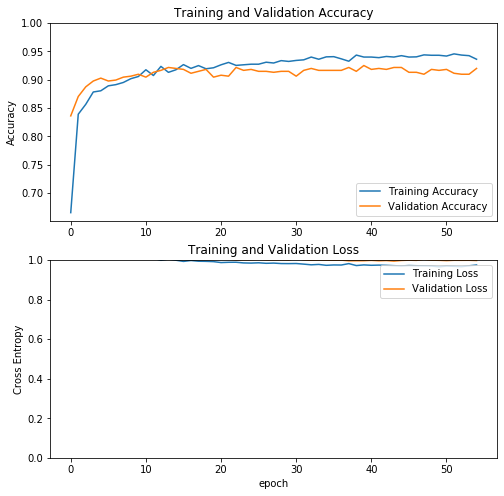

In [70]:
loss0, accuracy0 = model.evaluate(validation_dataset)

print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))


history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset,
                   callbacks=normal_callbacks)

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.savefig(os.path.join(MODEL_NAME_PATH,'stats.png'))
tf.saved_model.save(model, SAVED_MODEL_PATH)

In [71]:
#evaluate model
loss2, accuracy2 = model.evaluate(test_dataset)
print('Test accuracy :', accuracy2)
print('Test Loss :', loss2)

4/4 [==============================] - 0s 53ms/step - loss: 1.0100 - accuracy: 0.9219
Test accuracy : 0.921875
Test Loss : 1.0099672079086304


In [72]:
# visualize 
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predicted_batch = model.predict(image_batch)
predicted_batch = tf.squeeze(predicted_batch).numpy()
predicted_ids = np.argmax(predicted_batch, axis=-1)
print(predicted_ids)
#predicted_class_names = class_names[predicted_ids]
"""Let's look at the true labels and predicted ones."""
print("Labels: ", label_batch)
print("Predicted labels: ", predicted_ids)

[3 3 4 1 3 3 4 1 1 2 2 4 0 3 3 1 3 1 2 2 4 2 3 2 2 2 4 3 2 4 0 2]
Labels:  [3 3 2 1 3 3 4 1 1 2 3 4 0 3 3 1 3 1 2 2 4 0 3 2 3 2 4 3 2 4 0 2]
Predicted labels:  [3 3 4 1 3 3 4 1 1 2 2 4 0 3 3 1 3 1 2 2 4 2 3 2 2 2 4 3 2 4 0 2]


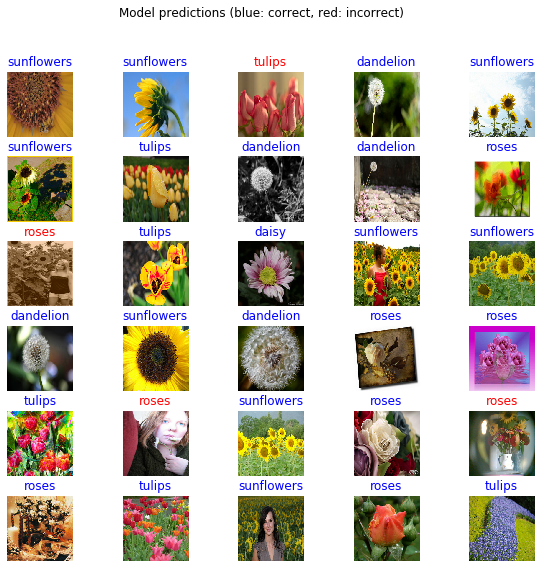

In [73]:
plt.figure(figsize=(10,9))
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.subplots_adjust(hspace = 0.3)
  plt.imshow((image_batch[n]).astype(np.uint8))
  color = "blue" if predicted_ids[n] == label_batch[n] else "red"
  plt.title(class_names[predicted_ids[n]], color=color)
  plt.axis('off')
    
_ = plt.suptitle("Model predictions (blue: correct, red: incorrect)")

In [74]:
# confusion prediction
image_batch_conf, label_batch_conf = test_dataset.as_numpy_iterator().next()
y_pred=np.argmax(model.predict(image_batch_conf),axis=1)
print(tf.math.confusion_matrix(labels=label_batch_conf, predictions=y_pred, num_classes=len(class_names)))

tf.Tensor(
[[5 0 0 0 0]
 [0 6 0 0 1]
 [0 0 7 0 1]
 [0 0 1 5 0]
 [0 0 1 0 5]], shape=(5, 5), dtype=int32)


In [75]:
#fine tuning
base_model.trainable = True

# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

model.compile(optimizer = optimizer_finetune,
              loss=loss_object, 
              metrics=['accuracy'])

model.summary()

establish_epoch = history.epoch[-1]
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         batch_size=final_batch_size,
                         validation_data=validation_dataset,
                         callbacks=finetune_callbacks)

#loss1, accuracy1 = model.evaluate(test_dataset)
#print('Test accuracy :', accuracy1)
#print('Test Loss :', loss1)
tf.saved_model.save(model, SAVED_FINETUNE_MODEL_PATH)

Number of layers in the base model:  155
Model: "FLOWER_BS32_EPOCH200_DROPOUT00"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
sequential_3 (Sequential)    (None, 224, 224, 3)       0         
_________________________________________________________________
tf_op_layer_RealDiv_3 (Tenso [(None, 224, 224, 3)]     0         
_________________________________________________________________
tf_op_layer_Sub_3 (TensorFlo [(None, 224, 224, 3)]     0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_3 ( (None, 1280)              0         
_____________________________________________________________

Epoch 96/400
89/90 [============================>.] - ETA: 0s - loss: 0.9217 - accuracy: 0.9849
Epoch 00096: loss did not improve from 0.92145
90/90 [==============================] - 6s 67ms/step - loss: 0.9217 - accuracy: 0.9850 - val_loss: 0.9705 - val_accuracy: 0.9317
Epoch 97/400
90/90 [==============================] - ETA: 0s - loss: 0.9238 - accuracy: 0.9815
Epoch 00097: loss did not improve from 0.92145
90/90 [==============================] - 7s 79ms/step - loss: 0.9238 - accuracy: 0.9815 - val_loss: 0.9686 - val_accuracy: 0.9369
Epoch 98/400
89/90 [============================>.] - ETA: 0s - loss: 0.9205 - accuracy: 0.9860
Epoch 00098: loss improved from 0.92145 to 0.92054, saving model to /home/williamkhoo/Desktop/projects/github/flower_classification/train_models/FLOWER_BS32_EPOCH200_DROPOUT00/check_point_model_finetune.h5
90/90 [==============================] - 8s 92ms/step - loss: 0.9205 - accuracy: 0.9860 - val_loss: 0.9681 - val_accuracy: 0.9369
Epoch 99/400
89/90 [==

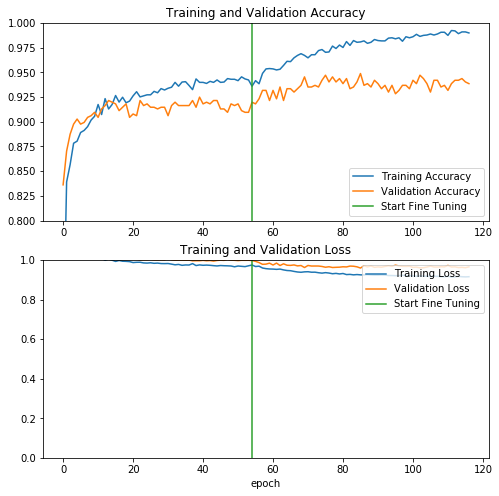

<Figure size 432x288 with 0 Axes>

In [76]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([establish_epoch,establish_epoch],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([establish_epoch,establish_epoch],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()
plt.savefig(os.path.join(MODEL_NAME_PATH,'stats_finetune.png'))

In [77]:
#evaluate finetune model
loss3, accuracy3 = model.evaluate(test_dataset)
print('Test accuracy :', accuracy3)
print('Test Loss :', loss3)

4/4 [==============================] - 0s 35ms/step - loss: 1.0077 - accuracy: 0.9062
Test accuracy : 0.90625
Test Loss : 1.0076704025268555


In [58]:
model = tf.keras.models.load_model(SAVED_FINETUNE_MODEL_PATH)
#model = tf.keras.models.load_model(SAVED_MODEL_PATH)
test_images_dir = os.path.join(CWD_PATH, 'test_images')

In [59]:
def pred(image_path,target_size = (224, 224)):
    file_name = os.path.basename(os.path.basename(image_path))
    im = plt.imread(image_path)
    resize = cv2.resize(im,target_size)
    test_image = np.expand_dims(resize, axis=0)
    predictions = model.predict(test_image)
    predicted_class = np.argmax(predictions)
    predicted_class2 = np.argmax(predictions, axis=1)
    scores = (predictions[0][predicted_class]) * 100
    print("{}, name {},class {}, score {:.2f}%".format(file_name, class_names[predicted_class], 
                                                                  predicted_class,scores))
    #return predictions_scores


def test_folder():
    lst = sorted(glob.glob("{}/*".format(test_images_dir)))
    i = 0
    print('getting folder {}, size: {}', test_images_dir, len(lst))
    for file in list(lst):
        pred(file)


In [60]:
test_folder()

getting folder {}, size: {} /home/williamkhoo/Desktop/projects/github/flower_classification/test_images 10
daisy.jpg, name daisy,class 0, score 100.00%
daisy2.jpg, name daisy,class 0, score 100.00%
dandelion.jpg, name dandelion,class 1, score 100.00%
dandelion2.jpg, name dandelion,class 1, score 100.00%
rose.jpg, name roses,class 2, score 100.00%
rose2.jpg, name roses,class 2, score 100.00%
sunflower.jpg, name sunflowers,class 3, score 100.00%
sunflower2.jpg, name sunflowers,class 3, score 100.00%
tulips.jpg, name tulips,class 4, score 100.00%
tulips2.jpg, name tulips,class 4, score 100.00%
